In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import graphviz
import numpy as np
import os
import pandas as pd
import optuna
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_auc_score, 
                             ConfusionMatrixDisplay, RocCurveDisplay, 
                             classification_report)

from sklearn.model_selection import (train_test_split, cross_val_score, 
                                     RandomizedSearchCV, GridSearchCV)
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import (LabelEncoder, OneHotEncoder, MinMaxScaler, 
                                    OrdinalEncoder, StandardScaler)

from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.ensemble import (RandomForestClassifier, StackingClassifier, 
                              VotingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import klib


C:\Users\Administrator\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# **1. Load Dataset**

In [2]:
df_trn = pd.read_csv('train.csv')
df_tst = pd.read_csv('test.csv')

In [3]:
df_trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353653 entries, 0 to 353652
Data columns (total 41 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         353653 non-null  int64  
 1   State                      353653 non-null  object 
 2   Sex                        353653 non-null  object 
 3   GeneralHealth              352798 non-null  object 
 4   PhysicalHealthDays         345169 non-null  float64
 5   MentalHealthDays           346556 non-null  float64
 6   LastCheckupTime            347270 non-null  object 
 7   PhysicalActivities         352859 non-null  object 
 8   SleepHours                 349494 non-null  float64
 9   RemovedTeeth               344795 non-null  object 
 10  HadAngina                  350785 non-null  object 
 11  HadStroke                  352757 non-null  object 
 12  HadAsthma                  352484 non-null  object 
 13  HadSkinCancer              35

# **2. Preprocessing**

## **2.1. 결측치 처리**

In [4]:
print('train data 결측치 비율 \n')

for col in df_trn.columns:
    msg = 'column: {:>25}\t Percent of NaN value: {:.2f}%'.format(col, 100 * df_trn[col].isnull().sum() / df_trn[col].shape[0])
    print(msg)

train data 결측치 비율 

column:                        ID	 Percent of NaN value: 0.00%
column:                     State	 Percent of NaN value: 0.00%
column:                       Sex	 Percent of NaN value: 0.00%
column:             GeneralHealth	 Percent of NaN value: 0.24%
column:        PhysicalHealthDays	 Percent of NaN value: 2.40%
column:          MentalHealthDays	 Percent of NaN value: 2.01%
column:           LastCheckupTime	 Percent of NaN value: 1.80%
column:        PhysicalActivities	 Percent of NaN value: 0.22%
column:                SleepHours	 Percent of NaN value: 1.18%
column:              RemovedTeeth	 Percent of NaN value: 2.50%
column:                 HadAngina	 Percent of NaN value: 0.81%
column:                 HadStroke	 Percent of NaN value: 0.25%
column:                 HadAsthma	 Percent of NaN value: 0.33%
column:             HadSkinCancer	 Percent of NaN value: 0.62%
column:                   HadCOPD	 Percent of NaN value: 0.42%
column:     HadDepressiveDisorder	 

In [5]:
print('test data 결측치 비율 \n')
for col in df_tst.columns:
    msg = 'column: {:>25}\t Percent of NaN value: {:.2f}%'.format(col, 100 * df_tst[col].isnull().sum() / df_tst[col].shape[0])
    print(msg)

test data 결측치 비율 

column:                        ID	 Percent of NaN value: 0.00%
column:                     State	 Percent of NaN value: 0.00%
column:                       Sex	 Percent of NaN value: 0.00%
column:             GeneralHealth	 Percent of NaN value: 0.27%
column:        PhysicalHealthDays	 Percent of NaN value: 2.39%
column:          MentalHealthDays	 Percent of NaN value: 1.92%
column:           LastCheckupTime	 Percent of NaN value: 1.88%
column:        PhysicalActivities	 Percent of NaN value: 0.20%
column:                SleepHours	 Percent of NaN value: 1.17%
column:              RemovedTeeth	 Percent of NaN value: 2.43%
column:                 HadAngina	 Percent of NaN value: 0.81%
column:                 HadStroke	 Percent of NaN value: 0.20%
column:                 HadAsthma	 Percent of NaN value: 0.30%
column:             HadSkinCancer	 Percent of NaN value: 0.65%
column:                   HadCOPD	 Percent of NaN value: 0.40%
column:     HadDepressiveDisorder	 P

In [6]:
# 수치형 변수 처리
df_trn['PhysicalHealthDays'].fillna(df_trn['PhysicalHealthDays'].mean(), inplace=True)
df_tst['PhysicalHealthDays'].fillna(df_tst['PhysicalHealthDays'].mean(), inplace=True)

df_trn['MentalHealthDays'].fillna(df_trn['MentalHealthDays'].mean(), inplace=True)
df_tst['MentalHealthDays'].fillna(df_tst['MentalHealthDays'].mean(), inplace=True)

df_trn['SleepHours'].fillna(df_trn['SleepHours'].mean(), inplace=True)
df_tst['SleepHours'].fillna(df_tst['SleepHours'].mean(), inplace=True)

df_trn['BMI'] = df_trn['BMI'].fillna(df_trn['WeightInKilograms'] / (df_trn['HeightInMeters'] ** 2))
df_tst['BMI'] = df_tst['BMI'].fillna(df_tst['WeightInKilograms'] / (df_tst['HeightInMeters'] ** 2))

# 변수 정의
id_cols = ['ID']
y_cols = ['HadHeartAttack']
col_mean = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours','GeneralHealth']
col_mode = [col for col in df_trn.columns if col not in id_cols+y_cols+col_mean]

# 범주형 변수
df_trn['GeneralHealth'].fillna('Good', inplace=True)
df_tst['GeneralHealth'].fillna('Good', inplace=True)

for column in col_mode:
    df_trn[column].fillna(df_trn[column].mode()[0], inplace=True)
    df_tst[column].fillna(df_tst[column].mode()[0], inplace=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15736\612249505.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_trn['PhysicalHealthDays'].fillna(df_trn['PhysicalHealthDays'].mean(), inplace=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15736\612249505.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

In [7]:
print('train data 결측치 비율 \n')

for col in df_trn.columns:
    msg = 'column: {:>25}\t Percent of NaN value: {:.2f}%'.format(col, 100 * df_trn[col].isnull().sum() / df_trn[col].shape[0])
    print(msg)

train data 결측치 비율 

column:                        ID	 Percent of NaN value: 0.00%
column:                     State	 Percent of NaN value: 0.00%
column:                       Sex	 Percent of NaN value: 0.00%
column:             GeneralHealth	 Percent of NaN value: 0.00%
column:        PhysicalHealthDays	 Percent of NaN value: 0.00%
column:          MentalHealthDays	 Percent of NaN value: 0.00%
column:           LastCheckupTime	 Percent of NaN value: 0.00%
column:        PhysicalActivities	 Percent of NaN value: 0.00%
column:                SleepHours	 Percent of NaN value: 0.00%
column:              RemovedTeeth	 Percent of NaN value: 0.00%
column:                 HadAngina	 Percent of NaN value: 0.00%
column:                 HadStroke	 Percent of NaN value: 0.00%
column:                 HadAsthma	 Percent of NaN value: 0.00%
column:             HadSkinCancer	 Percent of NaN value: 0.00%
column:                   HadCOPD	 Percent of NaN value: 0.00%
column:     HadDepressiveDisorder	 

## **2.2. 이상치 처리**

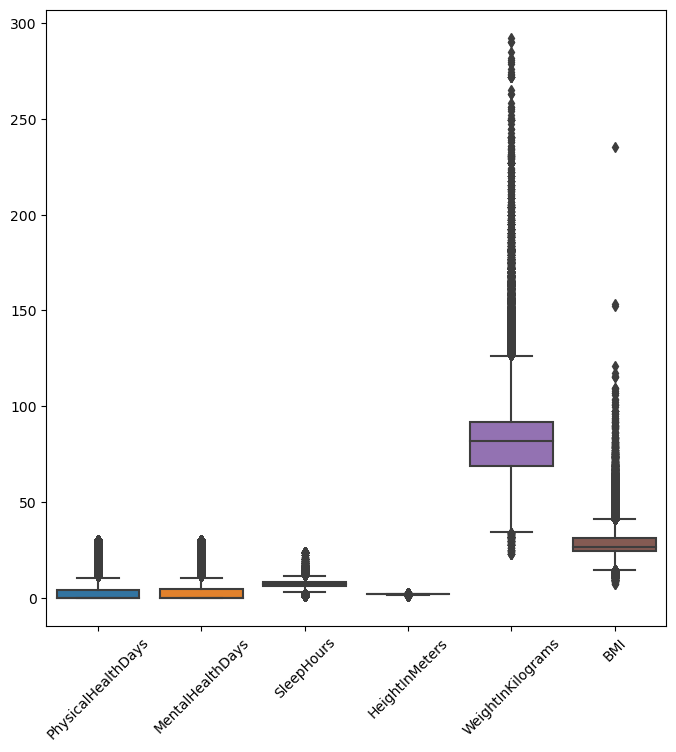

In [8]:
plt.figure(figsize=(8, 8)) 
sns.boxplot(data=df_trn[['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 
                         'HeightInMeters', 'WeightInKilograms', 'BMI']])
plt.xticks(fontsize=10, rotation=45) 
plt.show()

In [9]:
df_trn['SleepHours'] = df_trn['SleepHours'].clip(lower=3, upper=12)
df_tst['SleepHours'] = df_tst['SleepHours'].clip(lower=3, upper=12)

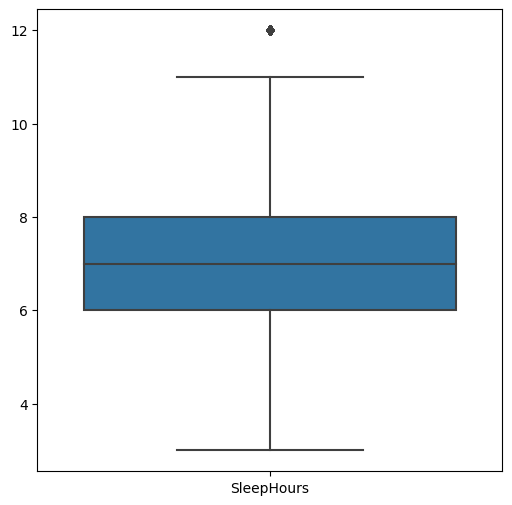

In [10]:
plt.figure(figsize=(6, 6)) 
sns.boxplot(data=df_trn[['SleepHours']])
plt.xticks(fontsize=10) 
plt.show()

# **3. Feature Engineering**

- 범주형 피처 중 **순서나 순위를 가지면서, 고윳값에 유의미한 차이가 있는 피처**는 **라벨 인코딩**을 수행함.
- 시각화 후 **발병률(타겟값이 1인 값)이 높은 순**으로 **큰 값으로 인코딩**하여 가중치를 줌.

## **3.1. Encoding(1)**

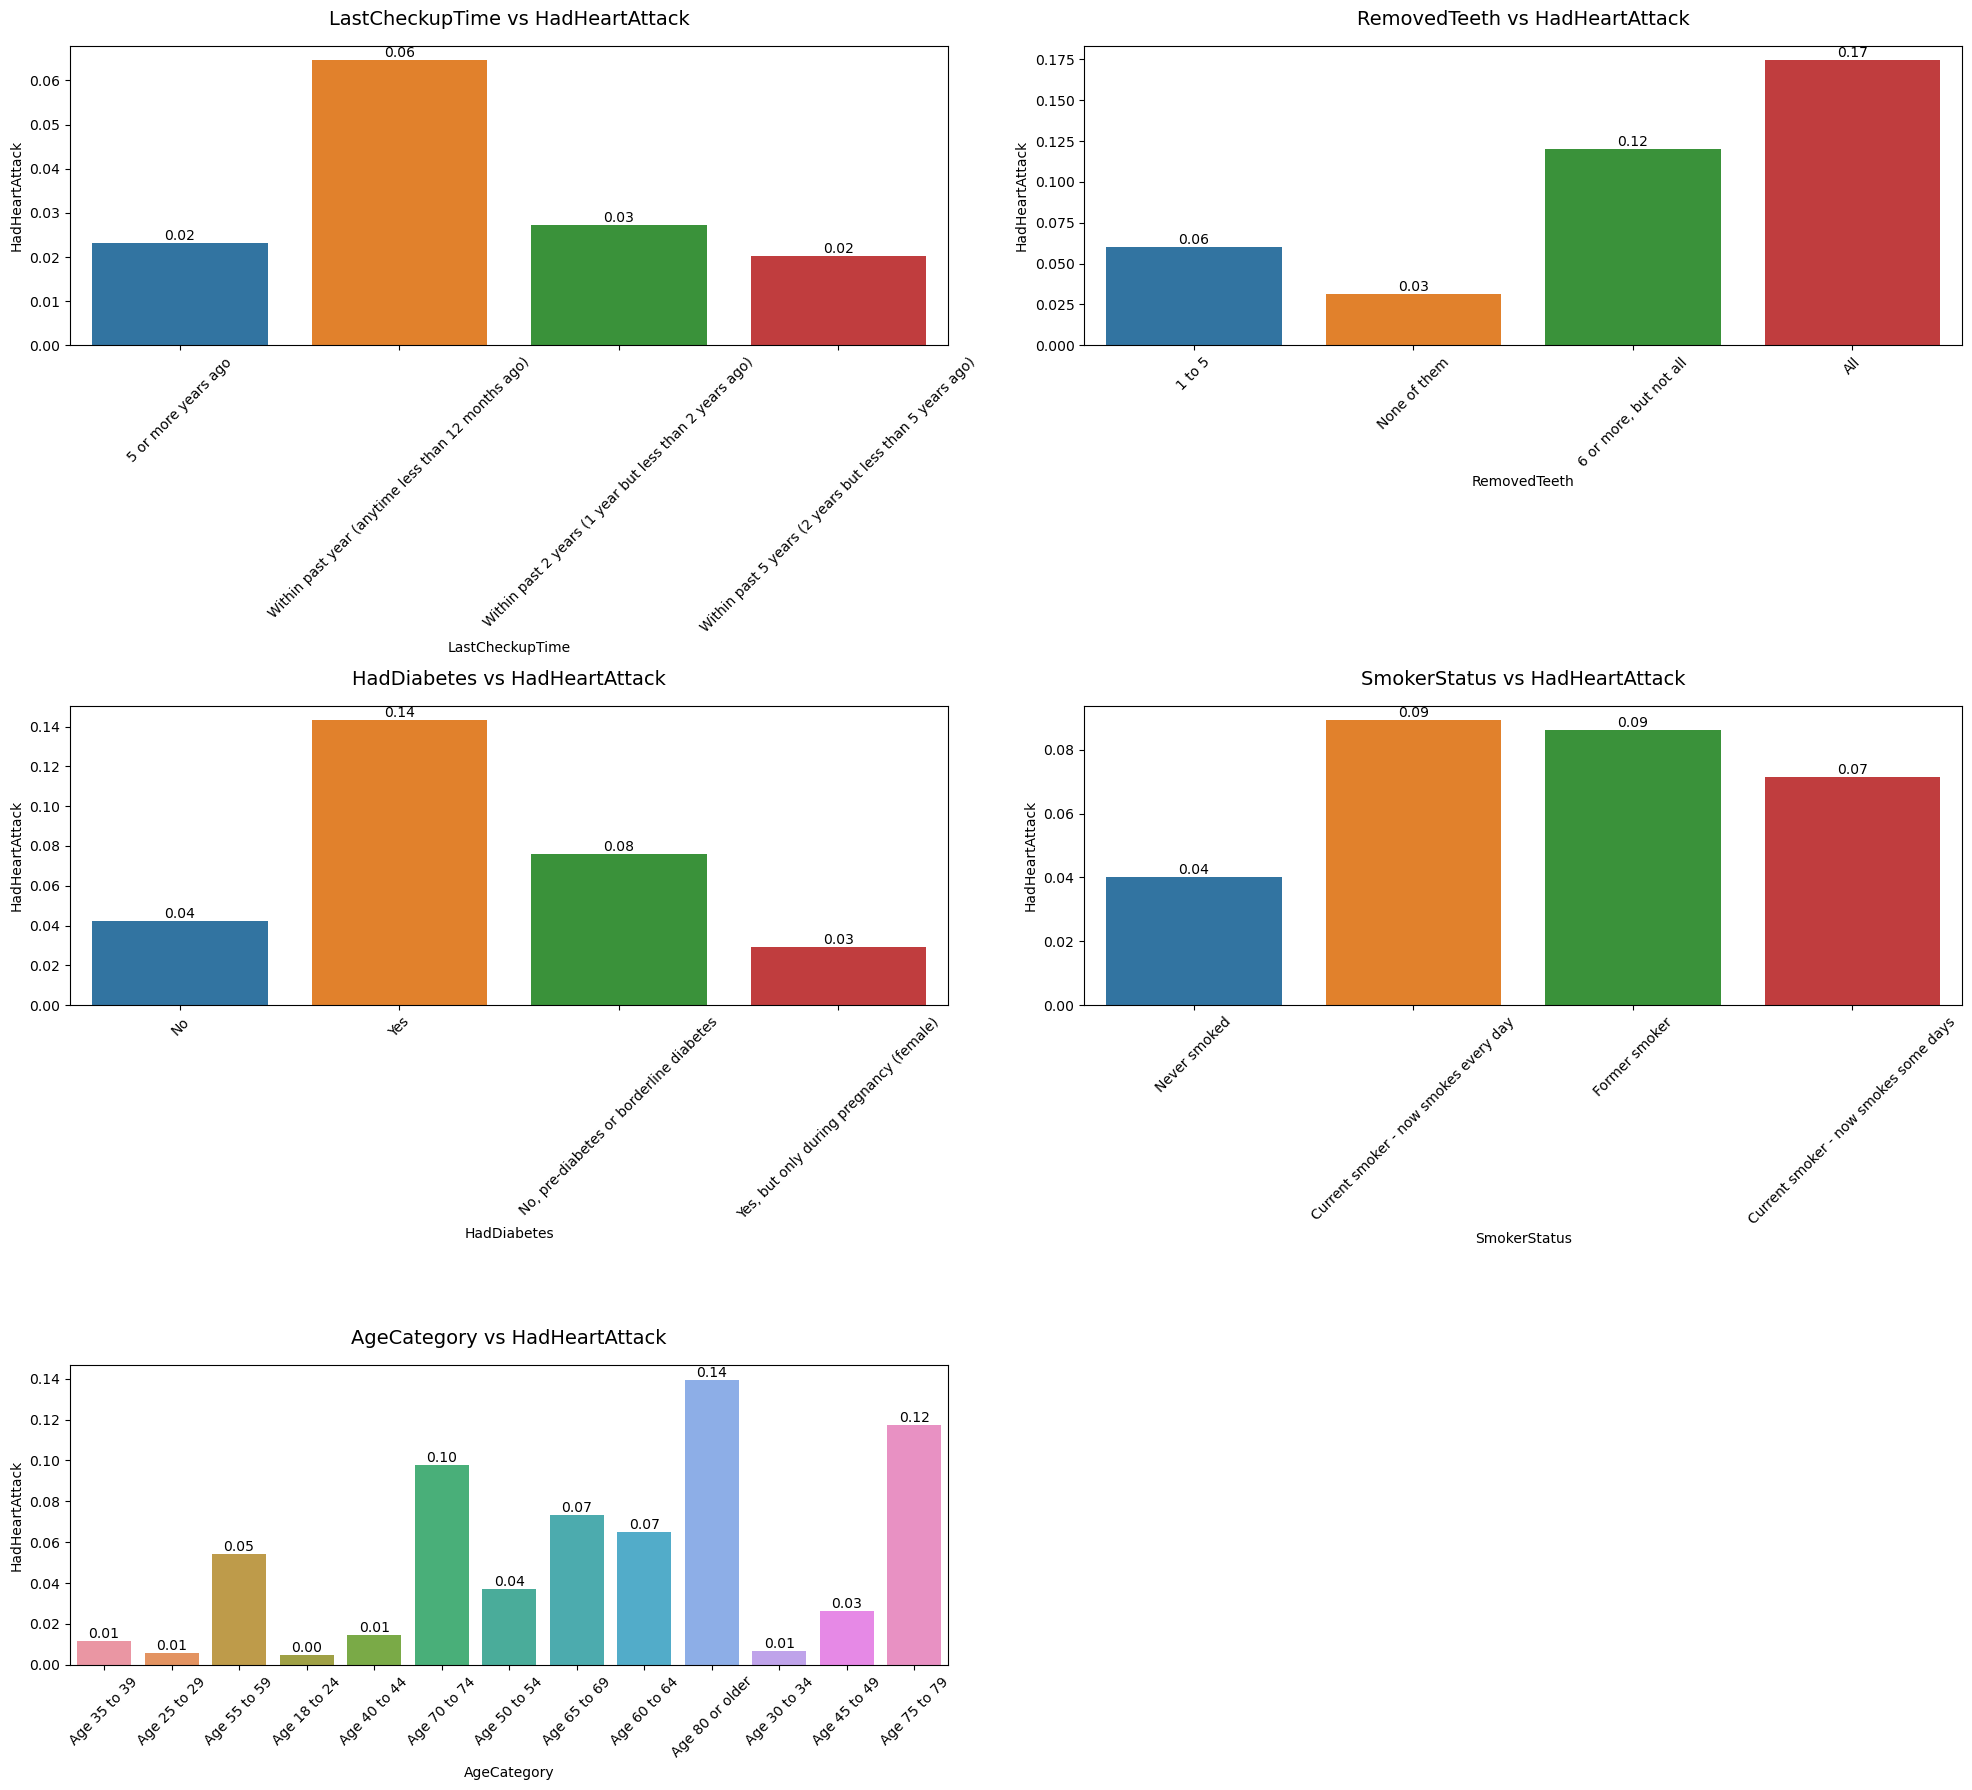

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

target = 'HadHeartAttack'
features = ['LastCheckupTime', 'RemovedTeeth',
            'HadDiabetes', 'SmokerStatus', 'AgeCategory']

num_cols = 2 
num_rows = (len(features) + num_cols - 1) // num_cols  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 6))
axes = axes.flatten()  

for i, feature in enumerate(features):
    sns.barplot(data=df_trn, x=feature, y=target, ax=axes[i], errorbar=None)
    axes[i].set_title(f"{feature} vs {target}", fontsize=14, pad=15)
    axes[i].tick_params(axis='x', rotation=45) 

    for p in axes[i].patches:
        height = p.get_height()
        if not pd.isnull(height) and height >= 0:  
            value = f"{height:.2f}"
            axes[i].annotate(value,
                             (p.get_x() + p.get_width() / 2., height),
                             ha='center', va='bottom', fontsize=10)

for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [12]:
def convert_last_checkup_time(value):
    if value == '5 or more years ago':
        return 0
    elif value == 'Within past year (anytime less than 12 months ago)':
        return 3
    elif value == 'Within past 2 years (1 year but less than 2 years ago)':
        return 2
    elif value == 'Within past 5 years (2 years but less than 5 years ago)':
        return 1
    else:
        return value 

df_trn['LastCheckupTime'] = df_trn['LastCheckupTime'].apply(convert_last_checkup_time)
df_tst['LastCheckupTime'] = df_tst['LastCheckupTime'].apply(convert_last_checkup_time)

In [13]:
def preprocess_removed_teeth(value):
    if pd.isna(value): 
        return value
    if value == 'None of them':
        return 0
    elif value == '1 to 5':
        return 1
    elif value == '6 or more, but not all':
        return 2
    elif value == 'All':
        return 3
    return value 
    
df_trn['RemovedTeeth'] = df_trn['RemovedTeeth'].apply(preprocess_removed_teeth)
df_tst['RemovedTeeth'] = df_tst['RemovedTeeth'].apply(preprocess_removed_teeth)

In [14]:
def preprocess_diabetes(value, sex):
    if value == 'Yes':
        return 2
    elif value == 'No':
        return 0
    elif value == 'No, pre-diabetes or borderline diabetes':
        return 1
    elif value == 'Yes, but only during pregnancy (female)' and sex == 'Female':
        return 1
    return 0  
    
df_trn['HadDiabetes'] = df_trn.apply(
    lambda row: preprocess_diabetes(row['HadDiabetes'], row['Sex']),
    axis=1
)

df_tst['HadDiabetes'] = df_tst.apply(
    lambda row: preprocess_diabetes(row['HadDiabetes'], row['Sex']),
    axis=1
)

In [15]:
def assign_smoker_risk(smoker_status):
    if smoker_status == 'Current smoker - now smokes every day':
        return 3
    elif smoker_status == 'Current smoker - now smokes some days':
        return 2
    elif smoker_status == 'Former smoker':
        return 1
    elif smoker_status == 'Never smoked':
        return 0
    return 0  

df_trn['SmokerStatus'] = df_trn['SmokerStatus'].apply(assign_smoker_risk)
df_tst['SmokerStatus'] = df_tst['SmokerStatus'].apply(assign_smoker_risk)

In [16]:
age_mapping = {
    'Age 18 to 24': 0,
    'Age 25 to 29': 1,
    'Age 30 to 34': 2,
    'Age 35 to 39': 3,
    'Age 40 to 44': 4,
    'Age 45 to 49': 5,
    'Age 50 to 54': 6,
    'Age 55 to 59': 7,
    'Age 60 to 64': 8,
    'Age 65 to 69': 9,
    'Age 70 to 74': 10,
    'Age 75 to 79': 11,
    'Age 80 or older': 12
}

df_trn['AgeCategory'] = df_trn['AgeCategory'].map(age_mapping)
df_tst['AgeCategory'] = df_tst['AgeCategory'].map(age_mapping)

## **3.2. Feature Generation**

In [17]:
df_trn['HighRisk_1'] = ((df_trn['SmokerStatus'] == 3) & (df_trn['RemovedTeeth'] == 3)).astype(int)
df_tst['HighRisk_1'] = ((df_tst['SmokerStatus'] == 3) & (df_tst['RemovedTeeth'] == 3)).astype(int)

In [18]:
df_trn['HighRisk_2'] = ((df_trn['AgeCategory'] >= 10) & (df_trn['PhysicalActivities'] == 'No')).astype(int)
df_tst['HighRisk_2'] = ((df_tst['AgeCategory'] >= 10) & (df_tst['PhysicalActivities'] == 'No')).astype(int)

In [19]:
df_trn['HighRisk_3'] = ((df_trn['AgeCategory'] >= 10) & (df_trn['HadDiabetes'].isin([1, 2]))).astype(int)
df_tst['HighRisk_3'] = ((df_tst['AgeCategory'] >= 10) & (df_tst['HadDiabetes'].isin([1, 2]))).astype(int)

In [20]:
df_trn['HighRisk_4'] = ((df_trn['HadAngina'] == 'Yes') & (df_trn['SmokerStatus'] >= 2)).astype(int)
df_tst['HighRisk_4'] = ((df_tst['HadAngina'] == 'Yes') & (df_tst['SmokerStatus'] >= 2)).astype(int)

In [21]:
df_trn['HighRisk_5'] = ((df_trn['HadAngina'] == 'Yes') & (df_trn['AgeCategory'] >= 9)).astype(int)
df_tst['HighRisk_5'] = ((df_tst['HadAngina'] == 'Yes') & (df_tst['AgeCategory'] >= 9)).astype(int)

In [22]:
df_trn['HighRisk_6'] = ((df_trn['HadStroke'] == 'Yes') & (df_trn['AgeCategory'] >= 9)).astype(int)
df_tst['HighRisk_6'] = ((df_tst['HadStroke'] == 'Yes') & (df_tst['AgeCategory'] >= 9)).astype(int)

In [23]:
df_trn['HighRisk_7'] = (
    (df_trn['DeafOrHardOfHearing'] == 'No') & 
    (df_trn['BlindOrVisionDifficulty'] == 'No') &
    (df_trn['DifficultyConcentrating'] == 'Yes') & 
    (df_trn['DifficultyWalking'] == 'Yes') & 
    (df_trn['DifficultyDressingBathing'] == 'Yes') & 
    (df_trn['DifficultyErrands'] == 'Yes')
).astype(int)


df_tst['HighRisk_7'] = (
    (df_tst['DeafOrHardOfHearing'] == 'No') & 
    (df_tst['BlindOrVisionDifficulty'] == 'No') &
    (df_tst['DifficultyConcentrating'] == 'Yes') & 
    (df_tst['DifficultyWalking'] == 'Yes') & 
    (df_tst['DifficultyDressingBathing'] == 'Yes') & 
    (df_tst['DifficultyErrands'] == 'Yes')
).astype(int)

## **3.3. Feature Selection**

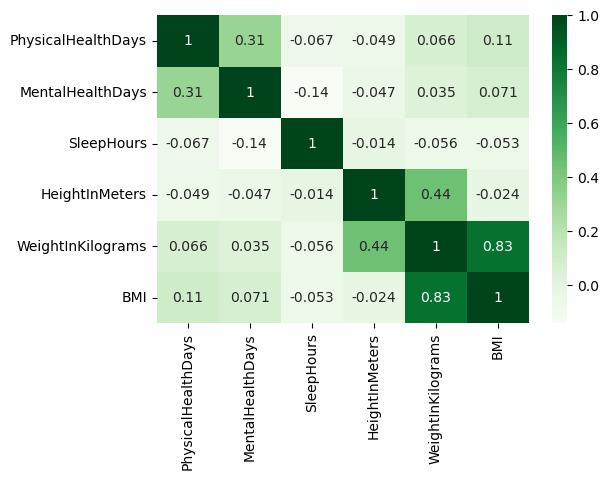

In [24]:
# 1. 독립변수 간 상관관계 확인 
corr = df_trn[['PhysicalHealthDays','MentalHealthDays','SleepHours',
                           'HeightInMeters','WeightInKilograms','BMI']].corr()
fig , ax = plt.subplots(figsize=(6 , 4))
sns.heatmap(corr ,annot= True , ax=ax , cmap= 'Greens');

In [25]:
# 'WeightInKilograms'와 'BMI'가 독립변수 간 가장 높은 상관계수 가짐
corr_weight_bmi = df_trn['WeightInKilograms'].corr(df_trn['BMI'])
print(f"WeightInKilograms와 BMI의 상관계수 : {corr_weight_bmi:.3f}")

WeightInKilograms와 BMI의 상관계수 : 0.834


In [26]:
# 'WeightInKilograms-종속변수' 간 상관계수
corr_weight_y = df_trn['WeightInKilograms'].corr(df_trn['HadHeartAttack'])
# 'BMI-종속변수' 간 상관계수
corr_bmi_y = df_trn['BMI'].corr(df_trn['HadHeartAttack']) 

In [27]:
print(f"WeightInKilograms와 HadHeartAttack의 상관계수 : {corr_weight_y:.3f}")
print(f"BMI와 HadHeartAttack의 상관계수 : {corr_bmi_y:.3f}")

WeightInKilograms와 HadHeartAttack의 상관계수 : 0.035
BMI와 HadHeartAttack의 상관계수 : 0.032


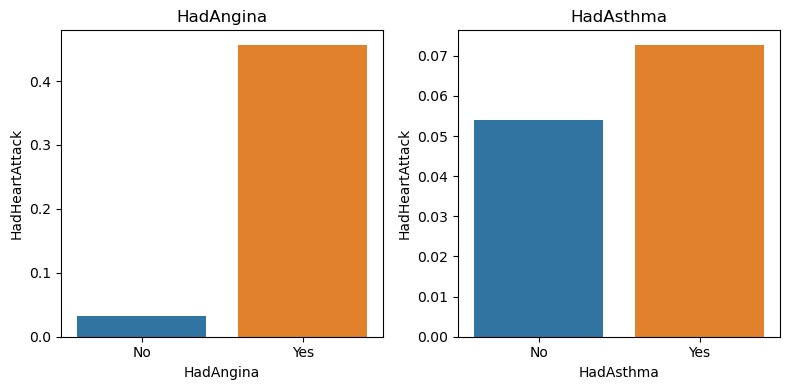

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [28]:
# 2. barplot을 통해 발병률 확인 -> HadAsthma피처의 영향력 낮다고 판단
import seaborn as sns
import matplotlib.pyplot as plt

# 두 개의 서브플롯을 만듭니다 (1행 2열)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# 첫 번째 그래프: BMI vs HadHeartAttack
sns.barplot(data=df_trn, x='HadAngina', y='HadHeartAttack', errorbar=None, ax=axes[0])
axes[0].set_title('HadAngina')

# 두 번째 그래프: 다른 변수로 그래프를 그릴 수 있습니다 (예: Age vs HadHeartAttack)
sns.barplot(data=df_trn, x='HadAsthma', y='HadHeartAttack', errorbar=None, ax=axes[1])
axes[1].set_title('HadAsthma')

# 그래프를 화면에 출력
plt.tight_layout()
plt.show()
plt.figure(figsize=(4, 4)) 

In [29]:
# 피처 삭제
drop_cols=['BMI','HadAsthma']
df_trn = df_trn.drop(columns=drop_cols)
df_tst = df_tst.drop(columns=drop_cols)

## **3.4. Scaling & Encoding(2) Pipeline**

- **수치형 변수**는 값의 범위를 일정한 수준으로 맞춰주는 **StandardScaling**
- 라벨 인코딩을 하지 않은 **나머지 범주형 변수**들은 **OneHotEncoding**

In [30]:
id_cols = ['ID']
y_cols = ['HadHeartAttack']
pass_cols = ['LastCheckupTime','SmokerStatus','RemovedTeeth','HadDiabetes','AgeCategory',
             'HighRisk_1', 'HighRisk_2','HighRisk_3','HighRisk_4','HighRisk_5','HighRisk_6','HighRisk_7']
num_cols = ['PhysicalHealthDays','MentalHealthDays','SleepHours','HeightInMeters','WeightInKilograms']
cat_cols = [col for col in df_trn.columns if col not in id_cols+y_cols+num_cols+pass_cols]

In [31]:
# 각각 범위가 다른 수치형 변수
df_trn.describe()

,ID,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,SleepHours,RemovedTeeth,HadDiabetes,SmokerStatus,AgeCategory,HeightInMeters,WeightInKilograms,HadHeartAttack,HighRisk_1,HighRisk_2,HighRisk_3,HighRisk_4,HighRisk_5,HighRisk_6,HighRisk_7
count,353653.000000,353653.000000,353653.000000,353653.000000,353653.000000,353653.000000,353653.000000,353653.000000,353653.000000,353653.000000,353653.000000,353653.000000,353653.000000,353653.000000,353653.000000,353653.000000,353653.000000,353653.000000,353653.000000
mean,221130.621581,4.318412,4.382608,2.663535,7.016456,0.664445,0.304640,0.560943,6.660153,1.701500,83.791490,0.056796,0.013174,0.076298,0.062352,0.007544,0.042850,0.027360,0.005421
std,127603.955969,8.550134,8.298383,0.771429,1.380566,0.876035,0.696364,0.891245,3.568509,0.103864,20.527293,0.231452,0.114019,0.265475,0.241794,0.086529,0.202519,0.163131,0.073425
min,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.910000,22.680000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,110644.000000,0.000000,0.000000,3.000000,6.000000,0.000000,0.000000,0.000000,4.000000,1.630000,68.490000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,221104.000000,0.000000,0.000000,3.000000,7.000000,0.000000,0.000000,0.000000,7.000000,1.680000,81.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,331642.000000,4.000000,4.382608,3.000000,8.000000,1.000000,0.000000,1.000000,10.000000,1.780000,91.630000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,442066.000000,30.000000,30.000000,3.000000,12.000000,3.000000,2.000000,3.000000,12.000000,2.410000,292.570000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
# 라벨 인코딩을 하지 않은 나머지 범주형 타입 변수
df_trn[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353653 entries, 0 to 353652
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   State                      353653 non-null  object
 1   Sex                        353653 non-null  object
 2   GeneralHealth              353653 non-null  object
 3   PhysicalActivities         353653 non-null  object
 4   HadAngina                  353653 non-null  object
 5   HadStroke                  353653 non-null  object
 6   HadSkinCancer              353653 non-null  object
 7   HadCOPD                    353653 non-null  object
 8   HadDepressiveDisorder      353653 non-null  object
 9   HadKidneyDisease           353653 non-null  object
 10  HadArthritis               353653 non-null  object
 11  DeafOrHardOfHearing        353653 non-null  object
 12  BlindOrVisionDifficulty    353653 non-null  object
 13  DifficultyConcentrating    353653 non-null  

In [33]:
# 숫자형 파이프라인
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])
num_pipeline = num_pipeline.set_output(transform='pandas')

# 범주형 파이프라인
cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=False))
])
cat_pipeline = cat_pipeline.set_output(transform='pandas')

In [34]:
col_transformer = ColumnTransformer(
    [
        ('num', num_pipeline, num_cols), 
        ('cat', cat_pipeline, cat_cols),
        ('pass', 'passthrough', pass_cols)
    ], 
    remainder='drop', 
    verbose_feature_names_out=False
)

# 결과 확인
col_transformer.set_output(transform='pandas')

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['PhysicalHealthDays', 'MentalHealthDays',
                                  'SleepHours', 'HeightInMeters',
                                  'WeightInKilograms']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['State', 'Sex', 'GeneralHealth',
                                  'PhysicalActivities', 'HadAngina',
                                  'HadStroke', 'HadSkinCancer', 'HadCOPD...
                                  'ChestScan', 'RaceEthnicityCategory',
                                  'AlcoholDrinkers', 'HIVTesting',
                                  'FluVaxLast12', 'PneumoVaxEver',
                                  'TetanusLast10Tdap', 'HighRiskLastYear',
                                  'CovidPos']),
                                ('pass', 'passthrough',
                                 ['LastCheckupTime', 'SmokerStatus',
                                  'RemovedTeeth', 'HadDiabetes', 'AgeCategory',
                                  'HighRisk_1', 'HighRisk_2', 'HighRisk_3',
                                  'HighRisk_4', 'HighRisk_5', 'HighRisk_6',
                                  'HighRisk_7'])],
                  verbose_feature_names_out=False)

In [35]:
df_trn_transformed = col_transformer.fit_transform(df_trn)
df_tst_transformed = col_transformer.transform(df_tst)

In [36]:
df_trn_transformed.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,State_Alabama,State_Alaska,State_Arizona,State_Arkansas,State_California,...,RemovedTeeth,HadDiabetes,AgeCategory,HighRisk_1,HighRisk_2,HighRisk_3,HighRisk_4,HighRisk_5,HighRisk_6,HighRisk_7
count,3.536530e+05,3.536530e+05,3.536530e+05,3.536530e+05,3.536530e+05,353653.000000,353653.000000,353653.000000,353653.000000,353653.000000,...,353653.000000,353653.000000,353653.000000,353653.000000,353653.000000,353653.000000,353653.000000,353653.000000,353653.000000,353653.000000
mean,1.068166e-16,-1.062440e-16,1.487606e-15,-3.458741e-15,8.590733e-16,0.010199,0.013160,0.022652,0.011845,0.024405,...,0.664445,0.304640,6.660153,0.013174,0.076298,0.062352,0.007544,0.042850,0.027360,0.005421
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.100475,0.113959,0.148792,0.108188,0.154304,...,0.876035,0.696364,3.568509,0.114019,0.265475,0.241794,0.086529,0.202519,0.163131,0.073425
min,-5.050702e-01,-5.281286e-01,-2.909287e+00,-7.620568e+00,-2.977089e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-5.050702e-01,-5.281286e-01,-7.362618e-01,-6.883983e-01,-7.454228e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-5.050702e-01,-5.281286e-01,-1.192008e-02,-2.069977e-01,-1.043242e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-3.724065e-02,-1.070304e-16,7.124216e-01,7.558037e-01,3.818585e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.003651e+00,3.087038e+00,3.609788e+00,6.821452e+00,1.017079e+01,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,2.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
df_trn_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353653 entries, 0 to 353652
Columns: 134 entries, PhysicalHealthDays to HighRisk_7
dtypes: float64(122), int32(7), int64(5)
memory usage: 352.1 MB


# **4. Modeling**

## **4.1. Train & Evaluate model**

In [ ]:
# 데이터 분할 및 SMOTE 적용
X_train, X_test, y_train, y_test = train_test_split(
    df_trn_transformed, df_trn[y_cols].values.ravel(),
    test_size=0.2, random_state=42, stratify=df_trn[y_cols].values.ravel()
)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# NumPy 배열로 변환
X_resampled = X_resampled.values if hasattr(X_resampled, "values") else X_resampled
y_resampled = y_resampled if isinstance(y_resampled, np.ndarray) else y_resampled.to_numpy()

# Optuna objective 함수 정의
def objective(trial):
    # RandomForest 하이퍼파라미터
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 50, 200)
    rf_max_depth = trial.suggest_int("rf_max_depth", 3, 10)

    # XGBoost 하이퍼파라미터
    xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 0.01, 0.3)
    xgb_max_depth = trial.suggest_int("xgb_max_depth", 3, 10)
    xgb_reg_alpha = trial.suggest_float("xgb_reg_alpha", 0.0, 10.0)
    xgb_reg_lambda = trial.suggest_float("xgb_reg_lambda", 0.0, 10.0)
    xgb_scale_pos_weight = trial.suggest_float("xgb_scale_pos_weight", 1.0, 3.0)

    # StratifiedKFold 설정
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, valid_idx in kf.split(X_resampled, y_resampled):
        X_train_fold, X_valid_fold = X_resampled[train_idx], X_resampled[valid_idx]
        y_train_fold, y_valid_fold = y_resampled[train_idx], y_resampled[valid_idx]

        # 모델 정의
        rf_model = RandomForestClassifier(
            n_estimators=rf_n_estimators,
            max_depth=rf_max_depth,
            random_state=42,
            class_weight="balanced",
        )
        xgb_model = XGBClassifier(
            use_label_encoder=False,
            eval_metric="logloss",
            learning_rate=xgb_learning_rate,
            max_depth=xgb_max_depth,
            reg_alpha=xgb_reg_alpha,
            reg_lambda=xgb_reg_lambda,
            scale_pos_weight=xgb_scale_pos_weight,
            n_estimators=100,  # 고정값, 필요시 추가 최적화 가능
            random_state=42,
        )

        # VotingClassifier 정의
        ensemble_model = VotingClassifier(
            estimators=[("rf", rf_model), ("xgb", xgb_model)],
            voting="soft",
        )

        # 모델 학습 및 검증
        ensemble_model.fit(X_train_fold, y_train_fold)
        y_pred_proba = ensemble_model.predict_proba(X_valid_fold)[:, 1]
        auc = roc_auc_score(y_valid_fold, y_pred_proba)
        auc_scores.append(auc)

    return np.mean(auc_scores)  # 평균 AUC 반환

# Optuna 실행
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# 최적 하이퍼파라미터 출력
print("Best trial:", study.best_trial.params)

# 최적 하이퍼파라미터 적용
best_params = study.best_trial.params

rf_model = RandomForestClassifier(
    n_estimators=best_params["rf_n_estimators"],
    max_depth=best_params["rf_max_depth"],
    random_state=42,
    class_weight="balanced",
)
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    learning_rate=best_params["xgb_learning_rate"],
    max_depth=best_params["xgb_max_depth"],
    reg_alpha=best_params["xgb_reg_alpha"],
    reg_lambda=best_params["xgb_reg_lambda"],
    scale_pos_weight=best_params["xgb_scale_pos_weight"],
    n_estimators=100,
    random_state=42,
)

# 최적화된 VotingClassifier 생성
final_model = VotingClassifier(
    estimators=[
        ("rf", rf_model),
        ("xgb", xgb_model)
    ],
    voting="soft",
)

# 최적 모델로 전체 데이터 학습
final_model.fit(X_resampled, y_resampled)

# 테스트 데이터 성능 평가
y_test_pred_proba = final_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f"Test ROC-AUC: {test_auc}")

[I 2024-11-25 15:38:44,638] A new study created in memory with name: no-name-a5034524-d46b-478d-a17a-f944e34c33c6
C:\Users\Administrator\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:39:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Administrator\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:41:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# **5. Predict**

In [ ]:
y_pred = final_model.predict(df_tst_transformed)

# **6. submission**

In [ ]:
df_submission = pd.read_csv('submission.csv')

In [ ]:
df_submission.head()

In [ ]:
df_submission['HadHeartAttack'] = y_pred

In [ ]:
df_submission

In [ ]:
# 새로운 파일로 저장하기
filename = 'my_answer.csv'
df_submission.to_csv(filename, index=False)